In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
from typing import List
import h5py
import io
from PIL import Image
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.distributions.dirichlet import Dirichlet
from torch.distributions.categorical import Categorical

import pytorch_lightning as pl
from pytorch_lightning.callbacks import DeviceStatsMonitor,LearningRateMonitor,TQDMProgressBar
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import segmentation_models_pytorch as smp


#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import evidence_loss
import epipolar_geometry

import torch.nn.functional as F


from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import Resize


import uncertain_fusion
from  vkitti_dataloader import SequentialImageVirtualKittiDataset
from  vkitti_dataloader import Preprocess


## Dataloader 

In [3]:
kornia_transform = Preprocess(resize_shape=64)
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/'

valid_dataset = SequentialImageVirtualKittiDataset(root, "valid", transforms=kornia_transform)

train_dataset = SequentialImageVirtualKittiDataset(root, "train", transforms=kornia_transform)

loaders = {
    "train": DataLoader(train_dataset, batch_size=10, shuffle=True, 
                        num_workers=int(16/2), persistent_workers=True, pin_memory=True), 
    "valid": DataLoader(valid_dataset, batch_size=10, shuffle=False, num_workers=int(16/2)),
}
print (len(train_dataset), len(valid_dataset))

Found 16968 2 single images sequences
Selecting 16968 two image sequences for mode valid
Total classes  7
Total classes  [1 2 3 4 5 0 6]
Found 25452 2 single images sequences
Selecting 25452 two image sequences for mode train
Total classes  7
Total classes  [1 2 3 4 5 0 6]
25452 16968


## Metrics

In [4]:
from torchmetrics import Metric
from torchmetrics.utilities import check_forward_full_state_property
class IoU(Metric):
    def __init__(self, n_classes, reduction="micro-imagewise"):
        super().__init__()
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="cat")
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="cat")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="cat")
        self.add_state("tn", default=torch.tensor(0), dist_reduce_fx="cat")
        self.n_classes = n_classes
        assert reduction=="micro-imagewise" or reduction=="micro"
        self.reduction=reduction

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        assert preds.ndim == 4
        assert target.ndim == 4
        self.tp, self.fp, self.fn, self.tn = smp.metrics.get_stats(preds.long(),
                                               target.long(), 
                                               mode="multiclass", 
                                               num_classes=self.n_classes)


    def compute(self):
       
        return smp.metrics.iou_score(self.tp, self.fp, self.fn, self.tn, reduction=self.reduction)


In [5]:

""" refer to https://github.com/jfzhang95/pytorch-deeplab-xception/blob/master/utils/metrics.py """
""" https://chowdera.com/2021/12/202112250822183610.html """

""" confusionMetric #  Be careful ： The horizontal line here represents the predicted value , 
The vertical represents the real value , Contrary to the previous Introduction  P\L P N P TP FP N FN TN """


class SegmentationMetric(torch.nn.Module):
    def __init__(self, numClass):
        super().__init__()
        self.numClass = numClass
        self.register_buffer("confusionMatrix", torch.zeros((self.numClass,) * 2))

    def pixelAccuracy(self):
        # return all class overall pixel accuracy  The proportion of correct pixels in the total pixels 
        # PA = acc = (TP + TN) / (TP + TN + FP + TN)
        acc = torch.diag(self.confusionMatrix).sum() / self.confusionMatrix.sum()
        return acc

    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = torch.diag(self.confusionMatrix) / self.confusionMatrix.sum(dim=1)
        return classAcc  #  What is returned is a list value , Such as ：[0.90, 0.80, 0.96], Presentation category 1 2 3 Prediction accuracy of each category 

    def meanPixelAccuracy(self):
        """ Mean Pixel Accuracy(MPA, Average pixel accuracy )： yes PA A simple upgrade of , Calculate the proportion of correctly classified pixels in each class , Then find the average of all classes . :return: """
        classAcc = self.classPixelAccuracy()
        meanAcc = torch.nanmean(classAcc)  # np.nanmean  averaging ,nan I met with Nan type , Its value is 0
        return meanAcc  #  Returns a single value , Such as ：np.nanmean([0.90, 0.80, 0.96, nan, nan]) = (0.90 + 0.80 + 0.96） / 3 = 0.89

    def IntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = torch.diag(self.confusionMatrix)  #  Take the value of the diagonal element , Returns a list of 
        union = torch.sum(self.confusionMatrix, dim=1) + torch.sum(self.confusionMatrix, dim=0) - torch.diag(
            self.confusionMatrix)  # axis = 1 Represents the value of the confusion matrix row , Returns a list of ; axis = 0 Means to take the value of the confusion matrix column , Returns a list of 
        IoU = intersection / union  #  Returns a list of , Its value is... Of each category IoU
        return IoU

    def meanIntersectionOverUnion(self):
        mIoU = torch.nanmean(self.IntersectionOverUnion())  #  Find each category IoU The average of 
        return mIoU

    def genConfusionMatrix(self, imgPredict, imgLabel):  #
        """  Same as FCN in score.py Of fast_hist() function , Calculating the confusion matrix  :param imgPredict: :param imgLabel: :return:  Confusion matrix  """
        # remove classes from unlabeled pixels in gt image and predict
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask] + imgPredict[mask]
        count = torch.bincount(label, minlength=self.numClass ** 2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        # print(confusionMatrix)
        return confusionMatrix

    def Frequency_Weighted_Intersection_over_Union(self):
        """ FWIoU, Frequency to weight ratio : by MIoU A kind of promotion of , This method sets the weight for each class according to its frequency of occurrence . FWIOU = [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)] """
        freq = torch.sum(self.confusionMatrix, dim=1) / torch.sum(self.confusionMatrix)
        iu = torch.diag(self.confusionMatrix) / (
                torch.sum(self.confusionMatrix, dim=1) + torch.sum(self.confusionMatrix, dim=0) -
                torch.diag(self.confusionMatrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)  #  Get the confusion matrix 
        return self.confusionMatrix

    def reset(self):
        self.confusionMatrix = torch.zeros((self.numClass, self.numClass)).type_as(self.confusionMatrix)
        #self.register_buffer("confusionMatrix", torch.zeros((self.numClass,) * 2))

In [6]:
seg_metric = SegmentationMetric(numClass=7)

In [7]:
b = torch.randint(low=0, high=7, size=(3,1, 7, 7))
c = torch.randint(low=0, high=7, size=(3,1, 7, 7))
seg_metric.addBatch(b,c)


tensor([[3., 1., 4., 3., 7., 4., 2.],
        [1., 3., 3., 2., 2., 5., 4.],
        [4., 1., 2., 0., 1., 3., 3.],
        [3., 4., 4., 3., 4., 1., 3.],
        [2., 3., 1., 5., 2., 2., 5.],
        [2., 4., 5., 4., 5., 2., 3.],
        [4., 4., 3., 3., 2., 4., 2.]])

In [8]:
print (seg_metric.Frequency_Weighted_Intersection_over_Union())
print (seg_metric.meanIntersectionOverUnion())
print (seg_metric.IntersectionOverUnion())
print (seg_metric.meanPixelAccuracy())
print (seg_metric.classPixelAccuracy())
print (seg_metric.pixelAccuracy())


tensor(0.0619)
tensor(0.0620)
tensor([0.0750, 0.0811, 0.0588, 0.0769, 0.0488, 0.0455, 0.0476])
tensor(0.1179)
tensor([0.1250, 0.1500, 0.1429, 0.1364, 0.1000, 0.0800, 0.0909])
tensor(0.1156)


## Lightning

In [9]:
class SequenceVkitiModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, epipolar_propagation, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )
        #Freezing the network
        for param in self.model.parameters():
            param.requires_grad = False
    
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.n_classes = out_classes
                        
        self.loss_fn = evidence_loss.edl_mse_loss
        
        self.epipolar_propagation = epipolar_propagation
        
        #self.conv_1d = torch.nn.Conv2d(in_channels=2*self.n_classes, out_channels=self.n_classes, kernel_size=1)
        self.val_0_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.val_1_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        self.OneD_fusion_iou = IoU(n_classes=self.n_classes, reduction="micro-imagewise")
        
        self.val_0_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.val_1_seg_metric = SegmentationMetric(self.n_classes).cuda()
        self.OneD_fusion_seg_metric = SegmentationMetric(self.n_classes).cuda()
       
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes, normalize='true')
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
       
        
        self.conv_1d = torch.nn.Sequential(
                          torch.nn.Conv2d(in_channels=2*self.n_classes, 
                                       out_channels=self.n_classes, 
                                       kernel_size=3, 
                                       device=self.device),
                         torch.nn.Upsample(size=(256,256), mode = 'nearest') #Make the image size auto
                        )
        self.save_hyperparameters(ignore=['epipolar_propagation'])


        
    def log_special(self, normalFusion, c_or_ic, name, t):
        mean=torch.mean(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median=torch.median(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        mean_prob=torch.mean(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median_prob=torch.median(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        uncertain=torch.mean(self.n_classes/torch.sum(t, dim=1, keepdim=True)).cpu().numpy().round(decimals=2)
        if mean > 1.0: #only dirchlet have greater than 1 
            dirchlet = torch.mean(Dirichlet(t).entropy()).cpu().numpy().round(decimals=2)
            categorical = torch.mean(Categorical(t/torch.sum(t, dim=1, keepdim=True)
                                                    ).entropy()).cpu().numpy().round(decimals=2)
            
        else:
            mean = 0.0
            median = 0.0
            dirchlet = 0.0
            uncertain = 0.0
            categorical = torch.mean(Categorical(t).entropy()).cpu().numpy().round(decimals=2)
            
        return [normalFusion, c_or_ic, name, mean, median, mean_prob, 
                median_prob, uncertain, dirchlet, categorical]

    def single_batch_forward(self, image):
        mask = self.model(image)
        return mask
    
    def forward(self, batch):
        logits_mask0 = self.single_batch_forward(batch["image0"])
        propagate_mask0 = self.epipolar_propagation(logits_mask0, 
                                                     batch['depth0']/100,
                                                     batch['translation_0_to_1_camera_frame'],
                                                     batch['rotation_0_to_1_camera_frame'])
        
        logits_mask1 = self.single_batch_forward(batch["image1"].to(self.device))
      
        fused_mask = torch.concat((propagate_mask0,logits_mask1), dim=1)
        fused_mask = self.conv_1d(fused_mask)

        logits_mask0 = F.relu(logits_mask0) + 1
        logits_mask1 = F.relu(logits_mask1) + 1
        #fused_mask = F.relu(fused_mask) + 1
        
        return logits_mask0, propagate_mask0, logits_mask1, fused_mask
    
   
        
        
    def shared_step(self, batch, stage):
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert batch["image0"].ndim == 4
        
        bs, num_channels, height, width = batch["image0"].size()

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        assert height % 32 == 0 and width % 32 == 0

        batch["mask0"] = batch["mask0"].unsqueeze(dim=1)
        batch["mask1"] = batch["mask1"].unsqueeze(dim=1)
        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert batch["mask0"].ndim == 4
        assert batch["mask1"].ndim == 4
        
        logits_mask0, propagate_mask0, logits_mask1, fused_mask = self.forward(batch)
        
        fused_mask = fused_mask.permute(0,2,3,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        fused_mask = fused_mask.reshape(-1, self.n_classes)
        mask = torch.ravel(batch["mask1"])
        # [batch_size*height*width] -> [batch_size*height*width, n_classes] 
        mask = F.one_hot(mask.to(torch.long), self.n_classes)
        loss = self.loss_fn(fused_mask, mask, self.current_epoch, self.n_classes, 5)
        self.log(f"{stage}_evidential_loss", loss, prog_bar=True)
        
        #Getting back to shape
        fused_mask = fused_mask.reshape(bs,  height, width, self.n_classes)
        fused_mask = fused_mask.permute(0,3,1,2)
        fused_mask = F.relu(fused_mask) + 1
        
        #Logging
        self.val_0_iou.update(logits_mask0.argmax( dim=1, keepdim=True),batch["mask0"])
        self.log("val_0_iou", self.val_0_iou, prog_bar=True)
        self.val_1_iou.update(logits_mask1.argmax( dim=1, keepdim=True),batch["mask1"])
        self.log("val_1_iou", self.val_1_iou, prog_bar=True)
        self.OneD_fusion_iou.update(fused_mask.argmax( dim=1, keepdim=True),batch["mask1"])
        self.log("OneD_fusion_iou", self.OneD_fusion_iou, prog_bar=True)
        
        self.val_0_seg_metric.addBatch(logits_mask0.argmax( dim=1, keepdim=True), batch["mask0"])
        self.val_1_seg_metric.addBatch(logits_mask1.argmax( dim=1, keepdim=True), batch["mask1"])
        self.OneD_fusion_seg_metric.addBatch(fused_mask.argmax( dim=1, keepdim=True), batch["mask1"])
        return loss
      

    def shared_epoch_end(self, outputs, stage):
        self.log(stage+"val_0"+"_FrequencyIoU", 
                         self.val_0_seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=True)
        self.log(stage+"val_1"+"_FrequencyIoU", 
                         self.val_1_seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=True)
        self.log(stage+"OneD_fusion"+"_FrequencyIoU", 
                         self.OneD_fusion_seg_metric.Frequency_Weighted_Intersection_over_Union(), prog_bar=True)
        self.val_0_seg_metric.reset()
        self.val_1_seg_metric.reset()
        self.OneD_fusion_seg_metric.reset()
        return       

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx): 
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def configure_optimizers(self):
        optimizer=torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), lr=0.001)#, weight_decay=1e-5)
        #optimizer=torch.optim.AdamW( self.conv_1d.parameters(), lr=0.0001)#, weight_decay=1e-5)
        scheduler = CosineAnnealingLR(optimizer,T_max=self.trainer.max_epochs)
    
        return {'optimizer': optimizer,'lr_scheduler':scheduler}

In [10]:
IMG_SIZE = 256
old_k = np.array([[725.0087, 0, 620.5],
                   [0, 725.0087, 187],
                   [0, 0, 1]])

K = np.array([[725.0087*(IMG_SIZE/1242), 0, IMG_SIZE/2],
                   [0, 725.0087*(IMG_SIZE/375), IMG_SIZE/2],
                   [0, 0, 1]])

Kinv= np.linalg.inv(K)

print (K)
print (Kinv)

print (K)
print (Kinv)
epipolar_propagation = epipolar_geometry.EpipolarPropagation(K, 
                                           Kinv, 
                                           IMG_SIZE, 
                                           IMG_SIZE, 
                                           fill_empty_with_ones=True)
epipolar_propagation.cuda()
#model = SequenceVkitiModel("FPN", 
#                            "timm-mobilenetv3_small_minimal_100", 
#                            in_channels=3, 
#                            out_classes=7,
#                            epipolar_propagation=epipolar_propagation
#                           ).cuda()


#model.model = torch.load('vkitti_mobilenetv3_244s_10epoch_77a.pt')

model = SequenceVkitiModel("Unet", 
                            "resnet18", 
                            in_channels=3, 
                            out_classes=7,
                           epipolar_propagation=epipolar_propagation
                           ).cuda()
model.model = torch.load('vkitti_unet_50epoch_86a.pt')
#Freezing the network
for param in model.model.parameters():
    param.requires_grad = False
    

[[149.43818615   0.         128.        ]
 [  0.         494.93927253 128.        ]
 [  0.           0.           1.        ]]
[[ 0.00669173  0.         -0.85654145]
 [ 0.          0.00202045 -0.25861759]
 [ 0.          0.          1.        ]]
[[149.43818615   0.         128.        ]
 [  0.         494.93927253 128.        ]
 [  0.           0.           1.        ]]
[[ 0.00669173  0.         -0.85654145]
 [ 0.          0.00202045 -0.25861759]
 [ 0.          0.          1.        ]]
cuda


/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (IoU). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [11]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=1,
    callbacks=[LearningRateMonitor(logging_interval="step"), 
               TQDMProgressBar(refresh_rate=10)],
    check_val_every_n_epoch=10,
    #overfit_batches=2000
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(
    model, 
    train_dataloaders=loaders['train'], 
    val_dataloaders=loaders['valid'],
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                   | Type                | Params
----------------------------------------------------------------
0  | model                  | Unet                | 14.3 M
1  | epipolar_propagation   | EpipolarPropagation | 0     
2  | val_0_iou              | IoU                 | 0     
3  | val_1_iou              | IoU                 | 0     
4  | OneD_fusion_iou        | IoU                 | 0     
5  | val_0_seg_metric       | SegmentationMetric  | 0     
6  | val_1_seg_metric       | SegmentationMetric  | 0     
7  | OneD_fusion_seg_metric | SegmentationMetric  | 0     
8  | train_cm               | ConfusionMatrix     | 0     
9  | valid_cm               | ConfusionMatrix     | 0     
10 | conv_1d                | Sequential          | 889   
----------------------------------------------------------------
889       Trainable params
14.3 M    Non-trainable params
14.3 M    Total params
57.320    Total estimated model params

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=2,
    callbacks=[LearningRateMonitor(logging_interval="step"), 
               TQDMProgressBar(refresh_rate=10)],
    check_val_every_n_epoch=1,
)
trainer.validate(
    model, 
    dataloaders=loaders['valid'],
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


cpu
cuda:0
cuda:0
logits_mask1  tensor(1215.0706, device='cuda:0') tensor(2., device='cuda:0') tensor(9.8033, device='cuda:0')
uncertainty  tensor(1., device='cuda:0') tensor(0.0029, device='cuda:0')
fuse tensor(2434.6257, device='cuda:0') tensor(1., device='cuda:0') tensor(33.8531, device='cuda:0')


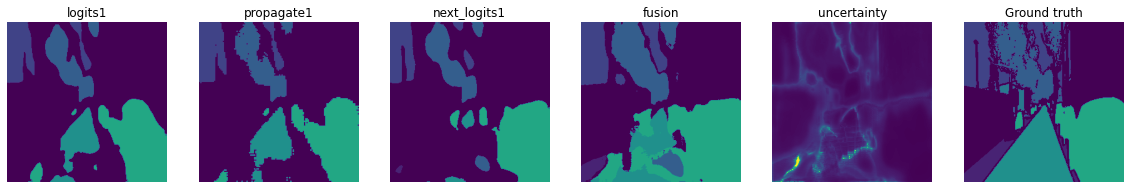

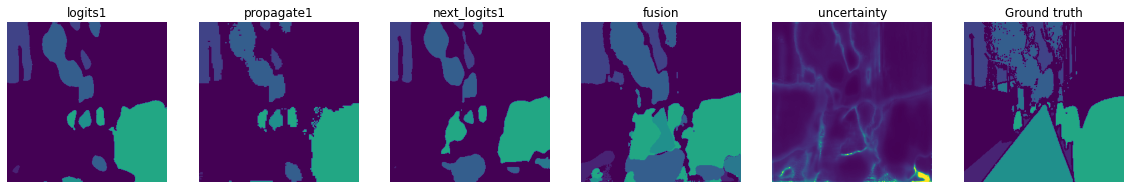

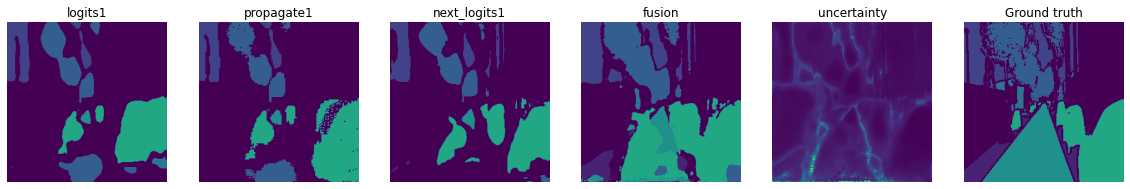

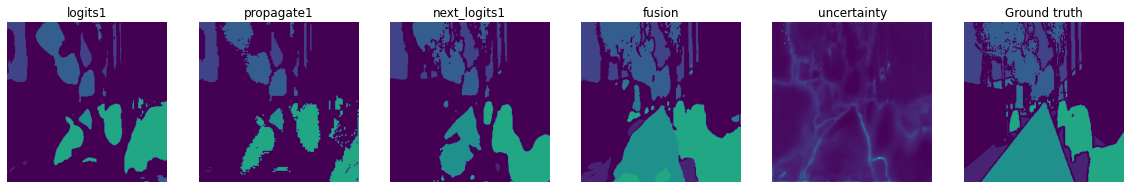

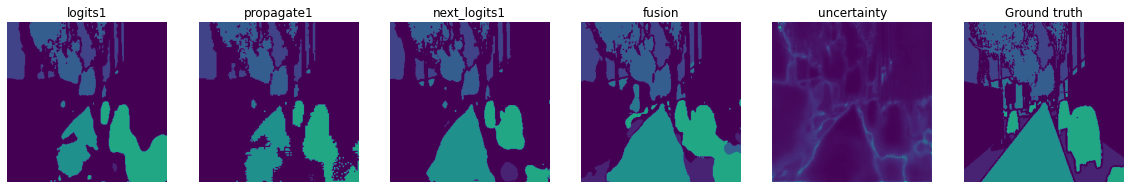

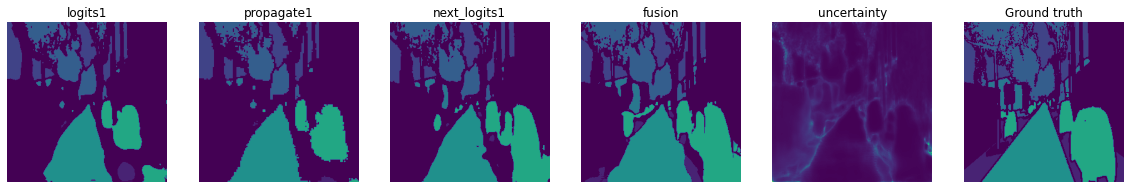

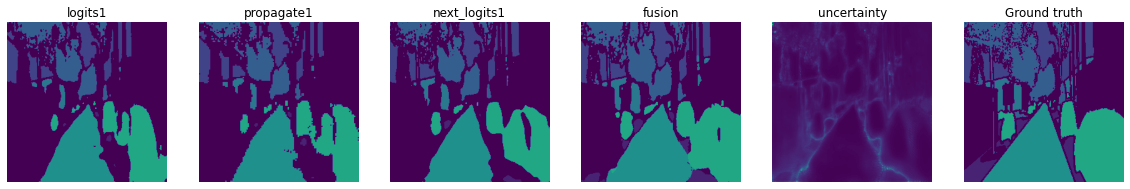

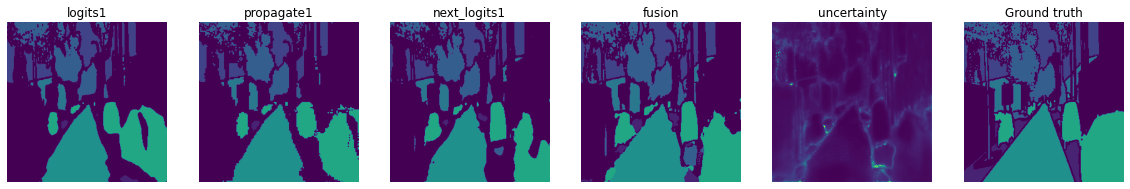

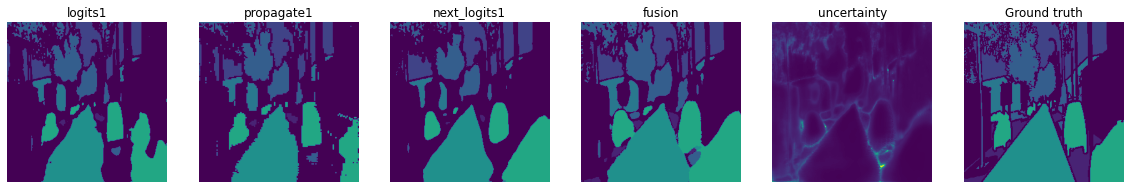

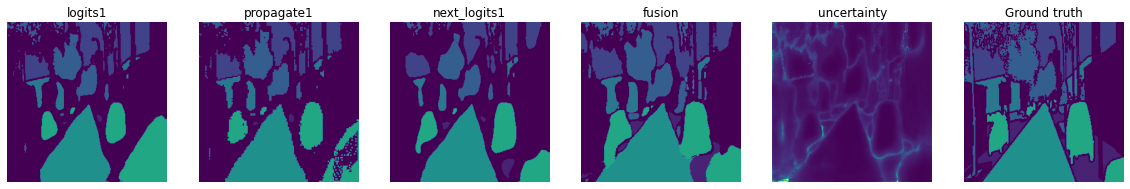

In [13]:
batch = next(iter(loaders['valid']))
bs, num_channels, height, width = batch["image0"].size()
print (batch['image0'].device)
with torch.no_grad():
    model.eval()
    model.cuda()
    batch['image0'] = batch['image0'].cuda()
    print (model.device)
    print (batch['image0'].device)
    logits_mask0, propagate_mask0, logits_mask1, fused_mask = model(batch)
    logits_mask0 = F.relu(logits_mask0) +1
    propagate_mask0= F.relu(propagate_mask0) +1
    logits_mask1 = F.relu(logits_mask1) +1
    fused_mask = F.relu(fused_mask) +1
    
    uncertainty = 7 / torch.sum(fused_mask, dim=1, keepdim=True)


print ('logits_mask1 ', logits_mask1.max(), logits_mask1.min(), logits_mask1.mean())
print ('uncertainty ', uncertainty.max(), uncertainty.min(), uncertainty.mean())
print ('fuse', fused_mask.max(), fused_mask.min(), fused_mask.mean())
for logits1, propagate1, next_logits1, f, u, gt_mask in zip(torch.argmax(logits_mask0, dim=1, keepdim=True), 
                                   torch.argmax(propagate_mask0, dim=1, keepdim=True), 
                                   torch.argmax(logits_mask1, dim=1, keepdim=True),
                                   torch.argmax(fused_mask, dim=1, keepdim=True),   
                                    uncertainty,
                                   batch['mask1']):

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 6, 1)
    plt.imshow(logits1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10)  # convert CHW -> HWC
    plt.title("logits1")
    plt.axis("off")

    plt.subplot(1, 6, 6)
    plt.imshow(gt_mask.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 6, 2)
    plt.imshow(propagate1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("propagate1")
    plt.axis("off")
  
    plt.subplot(1, 6, 3)
    plt.imshow(next_logits1.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("next_logits1")
    plt.axis("off")
    
    plt.subplot(1, 6, 4)
    plt.imshow(f.detach().cpu().numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("fusion")
    plt.axis("off")
    
    plt.subplot(1, 6, 5)
    plt.imshow(u.detach().cpu().numpy().squeeze(), vmin=0, vmax=1) # just squeeze classes dim, because we have only one class
    plt.title("uncertainty")
    plt.axis("off")
  
    #plt.savefig('result.png')
    plt.show()
    
del batch, logits_mask0, propagate_mask0, logits_mask1 , fused_mask, uncertainty